In [27]:
# Установка зависимостей
%pip install gymnasium[toy_text] numpy matplotlib imageio

  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Note: you may need to restart the kernel to use updated packages.


In [77]:
import numpy as np
import gymnasium as gym

# Создание окружения
env = gym.make("Taxi-v3", render_mode="rgb_array")
state_size = env.observation_space.n
action_size = env.action_space.n

# Q-таблица
q_table = np.zeros((state_size, action_size))

# Параметры обучения
alpha = 0.1 # learning rate
gamma = 0.9 # discount rate
epsilon = 1.0 # random action chance

epsilon_min = 0.01
epsilon_max = 1.0
epsilon_decay_rate = 0.0001

episodes = 50000
max_steps = 200
log_interval = 1000

# Сбор статистики
rewards_per_episode = []
steps_per_episode = []

best_avg = -np.inf

# Обучение
for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    step_count = 0
    done = False

    while not done and step_count < max_steps:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        q_table[state, action] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])

        state = next_state
        total_reward += reward
        step_count += 1

    epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-epsilon_decay_rate * episode)

    rewards_per_episode.append(total_reward)
    steps_per_episode.append(step_count)

    # Логирование
    if (episode + 1) % log_interval == 0:
        avg_reward = np.mean(rewards_per_episode[-log_interval:])
        print(f"Эпизод: {episode + 1}, Средняя награда: {avg_reward:.4f}, Epsilon: {epsilon:.4f}")

print("Обучение завершено. Q-таблица:")
print(q_table)


Эпизод: 1000, Средняя награда: -710.7890, Epsilon: 0.9059
Эпизод: 2000, Средняя награда: -446.3090, Epsilon: 0.8206
Эпизод: 3000, Средняя награда: -243.9130, Epsilon: 0.7435
Эпизод: 4000, Средняя награда: -147.5630, Epsilon: 0.6737
Эпизод: 5000, Средняя награда: -100.8660, Epsilon: 0.6105
Эпизод: 6000, Средняя награда: -74.7160, Epsilon: 0.5534
Эпизод: 7000, Средняя награда: -54.9440, Epsilon: 0.5017
Эпизод: 8000, Средняя награда: -41.4010, Epsilon: 0.4549
Эпизод: 9000, Средняя награда: -33.5580, Epsilon: 0.4125
Эпизод: 10000, Средняя награда: -26.0900, Epsilon: 0.3742
Эпизод: 11000, Средняя награда: -20.9650, Epsilon: 0.3396
Эпизод: 12000, Средняя награда: -16.4410, Epsilon: 0.3082
Эпизод: 13000, Средняя награда: -13.2460, Epsilon: 0.2798
Эпизод: 14000, Средняя награда: -9.9950, Epsilon: 0.2542
Эпизод: 15000, Средняя награда: -8.7180, Epsilon: 0.2309
Эпизод: 16000, Средняя награда: -6.9400, Epsilon: 0.2099
Эпизод: 17000, Средняя награда: -4.3010, Epsilon: 0.1909
Эпизод: 18000, Средняя

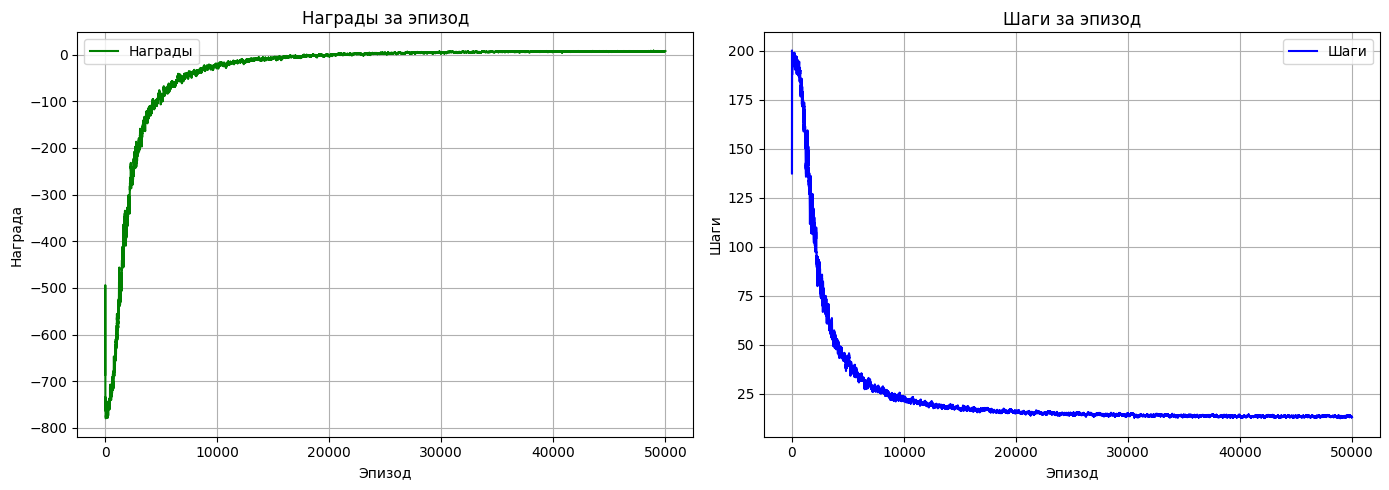

In [87]:
import matplotlib.pyplot as plt
import math

def smooth(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed

weight = 0.975
rewards_per_episode_smooth = smooth(rewards_per_episode, weight)
steps_per_episode_smooth = smooth(steps_per_episode, weight)

plt.figure(figsize=(14, 5))

# Средняя награда
plt.subplot(1, 2, 1)
plt.plot(range(episodes), rewards_per_episode_smooth, label="Награды", color="green")
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.title("Награды за эпизод")
plt.grid()
plt.legend()

# Среднее количество шагов
plt.subplot(1, 2, 2)
plt.plot(range(episodes), steps_per_episode_smooth, label="Шаги", color="blue")
plt.xlabel("Эпизод")
plt.ylabel("Шаги")
plt.title("Шаги за эпизод")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
import imageio

images_per_episode = []

test_episodes = 3
print("\nТестирование агента:\n")

for episode in range(test_episodes):
    state, _ = env.reset()
    images = []
    done = False
    step = 0

    while not done and step < max_steps:
        action = np.argmax(q_table[state])
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        images.append(env.render())
        step += 1
    
    print(f"Эпизод {episode + 1} - result_{episode + 1}.gif")
    
    images_per_episode.append(images)

for episode in range(test_episodes):
    imageio.mimsave(f'result_{episode + 1}.gif', images_per_episode[episode], duration=500, loop=0)

env.close()



Тестирование агента:

Эпизод 1 - result_1.gif
Эпизод 2 - result_2.gif
Эпизод 3 - result_3.gif


Для тренировки агента использовался метод *Q-Learning*. Среда *Taxi v3* из *Toy Text*

**Результаты:**

*Эпизод 1:*

![result](result_1.gif)

*Эпизод 2:*

![result](result_2.gif)

*Эпизод 3:*

![result](result_3.gif)